# 24FS\_I4DS27: Adversarial Attacks - Wie kann KI überlistet werden? <br> 10-UAP-Notebook

In diesem Notebook betrachten wir die unterschiedlichen UAPs an, die durch die Pipeline generiert wird.

In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

import numpy as np
import torch
import matplotlib.pyplot as plt
import yaml

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (16, 8)

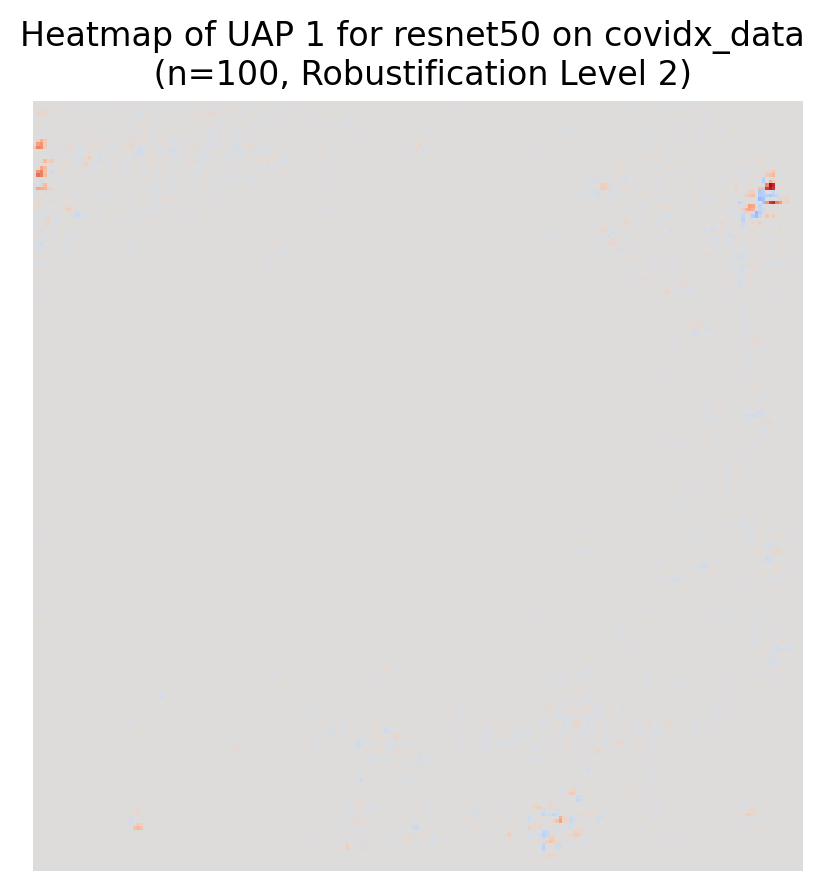

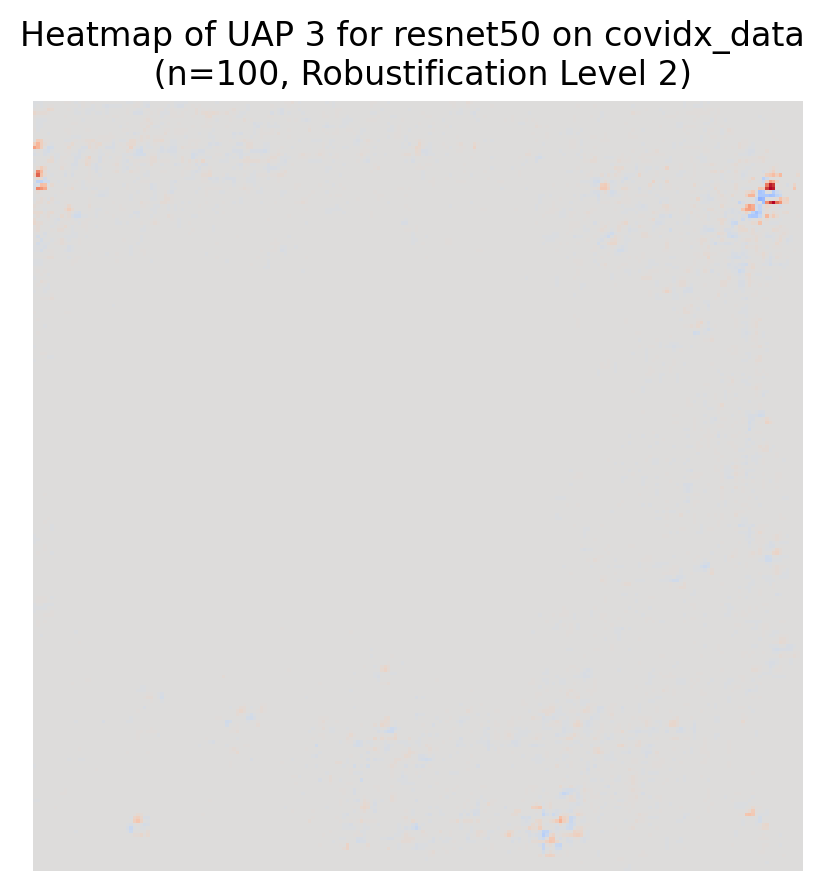

In [56]:
class UAP_EDA:
    def __init__(self, model, dataset, n_image, robustification_level=0):
        self.model = model
        self.dataset = dataset
        self.n_image = n_image
        self.robustification_level = robustification_level

        if robustification_level is not None:
            self.uaps_examples = self.read_perturbations(robustification_level)

    def read_perturbations(self, n_robustification):
        uap_path = f"robustified_models/{self.model}-{self.dataset}-n_{self.n_image}-robustification_{n_robustification}/01_UAPs_pre_robustification/UAPs_tensor.pt"
        if os.path.isfile(uap_path):
            return torch.load(uap_path, map_location=torch.device('cpu')).detach()
        else:
            print(f"File not found at {uap_path}")
            return None

    def visualize_perturbations(self, max_robustification):
        for n_robustification in range(0, max_robustification):
            uaps = self.read_perturbations(n_robustification)
            if uaps is not None:
                fig, ax = plt.subplots(1, 5, figsize=(15, 3))
                for i in range(5):
                    uap = uaps[i]
                    perturbations = uap.mean(dim=0).cpu().squeeze().numpy().astype(int)
                    vmax = np.abs(perturbations).max()
                    im = ax[i].imshow(perturbations, cmap="coolwarm", vmin=-vmax, vmax=vmax)
                    ax[i].axis('off')
                    ax[i].set_title(f'UAP {i+1}')

                fig.suptitle(f'Heatmaps of UAPs for {self.model} on {self.dataset} (n={self.n_image}, Robustification Level {n_robustification})')
                plt.show()
            else:
                print(f"Skipping visualization for robustification level {n_robustification} due to missing file.")

    def statistical_perturbations(self, max_robustification):
        for n_robustification in range(0, max_robustification):
            uaps = self.read_perturbations(n_robustification)
            if uaps is not None:
                for i in range(5):
                    uap = uaps[i]
                    perturbations = uap.mean(dim=0).cpu().squeeze().numpy().astype(int)
                    print(f"UAP {i+1} (Robustification Level {n_robustification})")
                    print(f"Mean: {perturbations.mean()}")
                    print(f"Std: {perturbations.std()}")
                    print(f"Min: {perturbations.min()}")
                    print(f"Max: {perturbations.max()}")
                    print()
            else:
                print(f"Skipping statistical analysis for robustification level {n_robustification} due to missing file.")

    
    def visualize_boxplot(self, max_robustification):
        data = []
        labels = []

        for n_robustification in range(0, max_robustification):
            uaps = self.read_perturbations(n_robustification)
            if uaps is not None:
                for i in range(uaps.shape[0]):
                    perturbations = uaps[i].mean(dim=0).cpu().squeeze().numpy().astype(int).flatten()
                    data.append(perturbations)
                    labels.append(f"UAP {i+1} Level {n_robustification}")
        
        plt.figure(figsize=(12, 6))
        plt.boxplot(data, labels=labels, notch=True, patch_artist=True)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Perturbation Value')
        plt.title('Boxplot Distribution of UAP Pixel Value Across Different Robustification Levels')
        plt.grid(True)
        plt.show()


    def plot_histogram(self, max_robustification, bins=100):
        for n_robustification in range(0, max_robustification):
            uaps = self.read_perturbations(n_robustification)
            if uaps is not None:
                fig, axs = plt.subplots(1, 5, figsize=(15, 3), tight_layout=True)
                for i in range(5):
                    uap = uaps[i]
                    perturbations = uap.mean(dim=0).cpu().squeeze().numpy().astype(int).flatten()
                    axs[i].hist(perturbations, bins=bins, color='blue', alpha=0.7)
                    axs[i].set_title(f'UAP {i+1}')
                    axs[i].set_xlabel('Perturbation Value')
                    axs[i].set_ylabel('Frequency')

                fig.suptitle(f'Histograms of UAPs for {self.model} on {self.dataset} (n={self.n_image}, Robustification Level {n_robustification})')
                plt.show()
            else:
                print(f"Skipping histogram for robustification level {n_robustification} due to missing file.")


    def visualize_uap_example(self, n_uap):
        if self.uaps_examples is not None:
            i_uap = self.uaps_examples[n_uap]
            i_perturbations = i_uap.mean(dim=0).cpu().squeeze().numpy().astype(int)
            vmax = np.abs(i_perturbations).max()
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            plt.imshow(i_perturbations, cmap="coolwarm", vmin=-vmax, vmax=vmax)
            plt.axis('off')
            plt.title(f'Heatmap of UAP {n_uap} for {self.model} on {self.dataset} \n (n={self.n_image}, Robustification Level {self.robustification_level})')
            plt.show()
        else:
            print(f"UAP example not found for UAP {n_uap}.")

p = UAP_EDA("resnet50", "covidx_data", 100, robustification_level=2)
#p.visualize_perturbations(max_robustification=3)
#p.visualize_boxplot(max_robustification=3)
#p.plot_histogram(max_robustification=3)
p.visualize_uap_example(1)
p.visualize_uap_example(3)